# Raquamaton

### Basic Grid Functions

In [1]:
import math
import time
import drawsvg
import random


In [2]:
#DEFENITIONS
class Bit_Generator:
    def __next__(self):
        return [[random.choice([0,1]) for i in range(0,9)] for j in range(0,5)]

def draw_bits(example_bits, marked=None, mark_colour=None):
    """Draw the bits as a shaded grid, marking special points"""
    # Understanding this code is not important to the tutorial
    square_size = 20 # in pixels
    drawing = drawsvg.Drawing(square_size*len(example_bits[0]), square_size*len(example_bits))
    for row in range(len(example_bits)):
        for index, bit in enumerate(example_bits[row]):
            colour = '#00e000' if bit else '#e10000'
            rect = drawsvg.Rectangle(index*square_size,(len(example_bits)-1-row)*square_size,square_size,square_size, fill=colour)
            drawing.append(rect)
    if marked is None:
        marked = []
    for index, mark in enumerate(marked):
        # Mark each coordinate in the list `marked`
        x = mark[0]
        y = mark[1]
        colour = "#11f" if mark_colour is None else mark_colour
        circle = drawsvg.Circle((x+0.5)*square_size,(len(example_bits)-0.5-y)*square_size,square_size/6, fill=colour)
        drawing.append(circle)
    return drawing

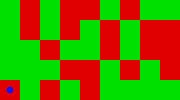

In [3]:
#Initiation
BG = Bit_Generator()
example_bits = next(BG)
example_bits
draw_bits(example_bits,[[0,0]])

In [4]:

len(example_bits)


5

In [6]:
def draw_neighbours(bits, point):
    """Draw the grid of bits and mark all cells surrounding and including the named point."""
    neighs = [[x,y] for x in range(point[0]-1,point[0]+2) for y in range(point[1]-1,point[1]+2)]
    return draw_bits(bits, neighs)

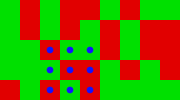

In [7]:
draw_neighbours(example_bits,[3,1])

In [34]:
def lookup(bit_grid, coordinates):
    #periodic boundary conditions
    i = coordinates[1]%len(bit_grid)
    j = coordinates[0]%len(bit_grid[i])
    return bit_grid[i][j]

def neighbours_cross(bit_grid, coordinate):
    """For the specified point in the grid return a dictionary of names to cell values.
    
    The names for the neighbours are from the CAMUS specification.
    """
    x_mid = coordinate[0]
    y_mid = coordinate[1]
    ordered = {"N":lookup(bit_grid,[x_mid,y_mid+1]),"E":lookup(bit_grid,[x_mid+1,y_mid]),
               "S":lookup(bit_grid,[x_mid,y_mid-1]),"W":lookup(bit_grid,[x_mid-1,y_mid])
              }
    return ordered

def neighbours_diag(bit_grid, coordinate):
    """For the specified point in the grid return a dictionary of names to cell values.
    
    The names for the neighbours are from the CAMUS specification.
    """
    x_mid = coordinate[0]
    y_mid = coordinate[1]
    ordered = {"NE":lookup(bit_grid,[x_mid+1,y_mid+1]),"SE":lookup(bit_grid,[x_mid+1,y_mid-1]),
               "SW":lookup(bit_grid,[x_mid-1,y_mid-1]),"NW":lookup(bit_grid,[x_mid-1,y_mid+1])
              }
    return ordered

In [9]:
neighbours_cross(example_bits,[5,1])

{'N': 0, 'E': 0, 'S': 1, 'W': 0}

In [10]:
s = list(neighbours_diag(example_bits,[2,1]).values())
s

[1, 1, 1, 1]

In [57]:
def bit_seq_to_int(bits):
    return int("".join(map(str, bits)),2)


In [12]:
bit_seq_to_int(s)

15

### Tesselation + Quantum Circuit

In [13]:
import qiskit
import pqca

In [14]:
size = [9,6]
initial_state = [0]*size[0]*size[1] 

In [382]:
tes_1 = pqca.tessellation.n_dimensional(size,[3,2]) 
tes_2 = pqca.tessellation.n_dimensional(size,[1,6]) 

IrregularCoordinateDimensions: [9, 6] and [6, 1] must be of the same length, and divide component-wise.

In [380]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
qs1 = 6
qc1 = qiskit.QuantumCircuit(qs1)
for i in range(qs1):
    qc1.h(i)

qc1.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     ├───┤
q_5: ┤ H ├
     └───┘

In [18]:
qs2 = 6
qc2 = qiskit.QuantumCircuit(qs2)
#two_qubit_circuit.h(0)
qc2.cx(0,1)
#two_qubit_circuit.h(3)
qc2.cz(3,2)
qc2.mcx([5,2],4)


qc2.draw()

q_0: ──■───────
     ┌─┴─┐     
q_1: ┤ X ├─────
     └───┘     
q_2: ──■────■──
       │    │  
q_3: ──■────┼──
          ┌─┴─┐
q_4: ─────┤ X ├
          └─┬─┘
q_5: ───────■──

In [20]:
update_frame_1 = pqca.UpdateFrame(tes_1, qiskit_circuit=qc1)
update_frame_2 = pqca.UpdateFrame(tes_2,  qiskit_circuit=qc2)

In [21]:
automaton = pqca.Automaton(initial_state, [update_frame_1, update_frame_2], pqca.backend.qiskit())

In [381]:
automaton.update_circuit.draw()

┌───┐          
 q_0: ┤ H ├──■───────
      ├───┤┌─┴─┐     
 q_1: ┤ H ├┤ X ├─────
      ├───┤└───┘     
 q_2: ┤ H ├──■────■──
      ├───┤  │    │  
 q_3: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
 q_4: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
 q_5: ┤ H ├───────■──
      ├───┤          
 q_6: ┤ H ├──■───────
      ├───┤┌─┴─┐     
 q_7: ┤ H ├┤ X ├─────
      ├───┤└───┘     
 q_8: ┤ H ├──■────■──
      ├───┤  │    │  
 q_9: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
q_10: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
q_11: ┤ H ├───────■──
      ├───┤          
q_12: ┤ H ├──■───────
      ├───┤┌─┴─┐     
q_13: ┤ H ├┤ X ├─────
      ├───┤└───┘     
q_14: ┤ H ├──■────■──
      ├───┤  │    │  
q_15: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
q_16: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
q_17: ┤ H ├───────■──
      ├───┤          
q_18: ┤ H ├──■───────
      ├───┤┌─┴─┐     
q_19: ┤ H ├┤ X ├─────
      ├───┤└───┘     
q_20: ┤ H ├──■────■──
      ├───┤  │    │  
q_21: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
q_22: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
q_23: ┤ H ├───────■──
      ├───┤          
q_24: ┤ H ├──■───────
      ├───┤┌─┴─┐     
q_25: ┤ H ├┤ X ├─────
      ├───┤└───┘     
q_26: ┤ H ├──■────■──
      ├───┤  │    │  
q_27: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
q_28: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
q_29: ┤ H ├───────■──
      ├───┤          
q_30: ┤ H ├──■───────
      ├───┤┌─┴─┐     
q_31: ┤ H ├┤ X ├─────
      ├───┤└───┘     
q_32: ┤ H ├──■────■──
      ├───┤  │    │  
q_33: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
q_34: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
q_35: ┤ H ├───────■──
      ├───┤          
q_36: ┤ H ├──■───────
      ├───┤┌─┴─┐     
q_37: ┤ H ├┤ X ├─────
      ├───┤└───┘     
q_38: ┤ H ├──■────■──
      ├───┤  │    │  
q_39: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
q_40: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
q_41: ┤ H ├───────■──
      ├───┤          
q_42: ┤ H ├──■───────
      ├───┤┌─┴─┐     
q_43: ┤ H ├┤ X ├─────
      ├───┤└───┘     
q_44: ┤ H ├──■────■──
      ├───┤  │    │  
q_45: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
q_46: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
q_47: ┤ H ├───────■──
      ├───┤          
q_48: ┤ H ├──■───────
      ├───┤┌─┴─┐     
q_49: ┤ H ├┤ X ├─────
      ├───┤└───┘     
q_50: ┤ H ├──■────■──
      ├───┤  │    │  
q_51: ┤ H ├──■────┼──
      ├───┤     ┌─┴─┐
q_52: ┤ H ├─────┤ X ├
      ├───┤     └─┬─┘
q_53: ┤ H ├───────■──
      └───┘

In [23]:
class Qubit_Generator:
    def __next__(self):
        many_bits = next(automaton)
        return [[many_bits[i+j] for j in range(size[0])] for i in range(size[1])]
QBG = Qubit_Generator()

In [24]:
#bits = next(QBG)
#bits
cached_states = [next(QBG) for _ in range(40)]
    

In [25]:
import ipywidgets
def visualise_next_n_steps(cached_states, n):
    def show_step(iteration):
        return draw_bits(cached_states[iteration])
    return ipywidgets.interact(show_step,iteration=ipywidgets.IntSlider(min=0, max=n-1, step=1, value=0))


In [26]:
visualise_next_n_steps(cached_states, 40)
pass

interactive(children=(IntSlider(value=0, description='iteration', max=39), Output()), _dom_classes=('widget-in…

### Bit Breakdown
Currently:
 - 'Tabla drums' (4x4)
 - 'Sitar' (5x5)

In [110]:
import numpy as np
def bit_breakdown(bit_grid):
    """Split the large grid into appropriate subgrids."""
    return {"tabla": np.array([row[0:4] for row in bit_grid]),
            "sitar": np.array([row[4:9] for row in bit_grid]),
           # "instruments": [row[5:9] for row in bit_grid],
    }

In [372]:
tabla = bit_breakdown(cached_states[2])['tabla']
tabla
sitar = bit_breakdown(cached_states[9])['sitar']
sitar


array([[0, 0, 1, 1, 1],
       [0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [106]:
criss_cross_sum(tabla,0)['diag']

array([[2., 3., 1., 3.],
       [2., 0., 3., 1.],
       [2., 3., 1., 3.],
       [2., 0., 3., 1.],
       [2., 3., 1., 3.],
       [2., 0., 3., 1.]])

In [303]:
def criss_cross_int(state):
    #creates new arrays with binary values from neighbours to integer
    wx = len(state)
    wy = len(state[0])
    cross_int = np.zeros((wx,wy))
    diag_int = np.zeros((wx,wy))
    for i in range(wx):
        for j in range(wy):
            cross_int[i,j] = bit_seq_to_int( np.array(list(neighbours_cross(state,[i,j]).values())))
            diag_int[i,j] =  bit_seq_to_int(np.array(list(neighbours_diag(state,[i,j]).values())))
    return {"cross": cross_int, "diag": diag_int}

def criss_cross_sum(state,shift=-1):
    #creates new arrays with summed values from neighbours
    wx = len(state)
    wy = len(state[0])
    cross_sum = np.zeros((wx,wy))
    diag_sum = np.zeros((wx,wy))
    for i in range(wx):
        for j in range(wy):
            cross_sum[i,j] = np.array(list(neighbours_cross(state,[i,j]).values())).sum()+shift
            diag_sum[i,j] =  np.array(list(neighbours_diag(state,[i,j]).values())).sum()+shift
    return {"cross": cross_sum, "diag": diag_sum}

def grid_to_seq(grid,len = 16, mod=20e3,shift = 0): 
    seq = np.array([float(i)%mod + shift if i > 0 else float(i)%-mod + shift for i in grid.flatten()])
    return seq[0:len]

In [302]:
-1 % 5
    

4

In [304]:
a = np.array([-999,0,1,6,-4,-1])
grid_to_seq(a,16,5)

array([-4.,  0.,  1.,  1., -4., -1.])

In [100]:
criss_cross_int(sitar)

{'cross': array([[13., 12.,  2., 14.,  0.],
        [12.,  3., 15.,  0.,  3.],
        [ 1., 15.,  0.,  3.,  0.],
        [13.,  0.,  3.,  0.,  0.],
        [ 0.,  7.,  4.,  0.,  4.],
        [13., 12.,  2., 14.,  0.]]),
 'diag': array([[ 8.,  6., 12.,  0.,  4.],
        [ 1., 13.,  2.,  7.,  0.],
        [ 9.,  2.,  7.,  0.,  2.],
        [ 0.,  7.,  0.,  2.,  0.],
        [ 9.,  8.,  6., 12.,  0.],
        [ 8.,  6., 12.,  0.,  4.]])}

In [203]:
criss_cross_sum(sitar)['cross']-criss_cross_sum(sitar)['diag']

array([[ 0.,  1., -1.,  2., -2.],
       [ 0.,  0.,  1., -1., -1.],
       [ 1.,  1., -1., -1.,  2.],
       [-1., -1., -1.,  2., -3.],
       [ 0.,  0.,  1., -2.,  3.],
       [ 0.,  1., -1.,  2., -2.]])

In [82]:
criss_cross_int(tabla)

{'cross': array([[ 3.,  0., 13.,  1.],
        [ 2., 12.,  0., 15.],
        [12.,  0., 15., 12.],
        [ 2., 11.,  8.,  7.],
        [ 3.,  0., 13.,  1.],
        [ 2., 12.,  0., 15.]]),
 'diag': array([[ 6., 11.,  1., 14.],
        [10.,  0., 13.,  8.],
        [ 6., 13.,  8.,  7.],
        [ 5.,  0., 11.,  1.],
        [ 6., 11.,  1., 14.],
        [10.,  0., 13.,  8.]])}

In [98]:
#grid to seq
criss_cross_int(tabla)['cross'].flatten()


array([ 3.,  0., 13.,  1.,  2., 12.,  0., 15., 12.,  0., 15., 12.,  2.,
       11.,  8.,  7.,  3.,  0., 13.,  1.,  2., 12.,  0., 15.])

for tabla:

    - bitgrid is on off?
    - cross is sample
    - diag is duration

for sitar:

    - cross is scale
    - diag is tuning/duration
    - bitgrid is onoff
    - sum (cross+diag) is octave
    - sum(cross) - sum(diag) is glide (-1,0,1) with (array.normalize * 2 - 1) in SC

In [193]:
onoff = grid_to_seq(criss_cross_int(sitar)['cross'],20)
onoff

array([13., 12.,  2., 14.,  0., 12.,  3., 15.,  0.,  3.,  1., 15.,  0.,
        3.,  0., 13.,  0.,  3.,  0.,  0.,  0.,  7.,  4.,  0.,  4., 13.,
       12.,  2., 14.,  0.])

In [199]:
#onoff = [3, 0, 2, 1, 2, 1, 0, 4, 1, 0, 4, 1, 2, 0, 8, 7, 3, 0, 2, 1, 2, 1, 0, 4]

client.send_message("/sitar/scale", grid_to_seq(criss_cross_int(sitar)['cross'],16))




In [141]:
-1%100

99

In [379]:
from pythonosc import udp_client

# Set up the OSC client
ip = "127.0.0.1"  # SuperCollider's IP address (localhost in this case)
port = 57120  # SuperCollider's default OSC port
client = udp_client.SimpleUDPClient(ip, port)

state = state + 1

tabla = bit_breakdown(cached_states[state])['tabla']
sitar = bit_breakdown(cached_states[state])['sitar']

tabla_len = 24
client.send_message("/tabla/onoff", grid_to_seq(tabla,tabla_len))
client.send_message("/tabla/samparr", grid_to_seq(criss_cross_int(tabla)['cross'],tabla_len,9))
client.send_message("/tabla/durarr", grid_to_seq(criss_cross_int(tabla)['diag'],tabla_len))
client.send_message("/tabla/amparr", grid_to_seq(criss_cross_sum(tabla,0)['diag'],tabla_len,6,1))

sitar_len = 30
client.send_message("/sitar/onoff", grid_to_seq(sitar,sitar_len,2))               
client.send_message("/sitar/scale", grid_to_seq(criss_cross_int(sitar)['cross'],sitar_len))
client.send_message("/sitar/durarr", grid_to_seq(criss_cross_int(sitar)['diag'],sitar_len))
octave = criss_cross_sum(sitar)['cross']+criss_cross_sum(sitar)['diag']
octave = octave - octave.min() - 1
client.send_message("/sitar/octave", grid_to_seq(octave,sitar_len,2,-0.1))
client.send_message("/sitar/glide" , abs(grid_to_seq(criss_cross_sum(sitar)['cross']-criss_cross_sum(sitar)['diag'],sitar_len,3)))
#client.send_message("/sitar/glide", grid_to_seq(criss_cross_sum(sitar)['cross']-criss_cross_sum(sitar)['diag'],16,3))


#decaymessage range(-3,2)


state







23

In [365]:
abs(grid_to_seq(criss_cross_sum(sitar)['cross']-criss_cross_sum(sitar)['diag'],16,2))
grid_to_seq(sitar,16,2)


array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.])

In [236]:
client.send_message("/sitar/octave", grid_to_seq(criss_cross_sum(sitar)['cross']+criss_cross_sum(sitar)['diag']))


In [221]:
client.send_message("/sitar/onoff", grid_to_seq(sitar))

In [164]:
grid_to_seq(criss_cross_int(tabla)['cross'],11)

array([3, 0, 2, 1, 2, 1, 0, 4, 1, 0, 4, 1, 2, 0, 8, 7, 3, 0, 2, 1, 2, 1,
       0, 4])